In [1]:
"""In this notebook we calculate growth rates for the 
magnetoacoustic cyclotron instability of fusion born ions 
produced at 3.5MeV."""
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
from KineticDispersion import Solver, Species
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
#%matplotlib notebook

In [2]:
"""Define physical constants"""
e0 = 8.85E-12 #Permittivity of free space
mu0 = 1.26E-6 #Permeability of free space
e = 1.6E-19 #Electron charge
kb = 1.38E-23 #Boltzmann constant
me = 9.11E-31 #Electron mass 
md = 3.344e-27 #Deuterium mass
ma = 6.644E-27 #Alpha mass
ev = 11500 #Temperature of one electron volt

In [3]:
labelsize=9
fontsize=12

def singleFigure():
    """Sets up a single panel figure. """
    fig, ax = plt.subplots(1, 1, figsize=(3.8, 3.42))
    plt.subplots_adjust(left=0.13, right=0.87, top=0.98, bottom=0.14)
    ax.tick_params('x', labelsize=labelsize)
    ax.tick_params('y', labelsize=labelsize)
    lbaxes = fig.add_axes([0.11, 0.14, 0.78, 0.84], frameon=False)
    lbaxes.set_xticks([])
    lbaxes.set_yticks([])
    lbaxes.yaxis.tick_right()
    lbaxes.tick_params('y', labelsize=labelsize)
    lbaxes.yaxis.set_label_position("right")
    return fig, ax, lbaxes

In [4]:
"""All variables are defined in SI units. """
Te = 1000*ev#Electron temperature
Td = 1000*ev#Deuteron temperature
Ta = 1000*ev#Alpha temperature
B = 2.1#Background magnetic field
ne = 1E19#Electron number density
nb = 1E-3*ne#Number density of background beam ions
nd = ne - nb*2#Number density of background Deuterons

eBeam = 3500000*e#Energy of beam

vthe = (kb*Te/me)**0.5 #Electron thermal velocity
vthd = (kb*Td/md)**0.5 #Deuteron thermal velocity
vtha = (kb*Ta/ma)**0.5 #Alpha thermal velocity
vb = (2*eBeam/ma)**0.5 #Velocity of ring beam

wpe = (ne*e**2/(e0*me))**0.5 #Electron plasma frequency
wce = e*B/me #Electron cyclotron frequency
wcd = e*B/md #Deuteron cyclotron frequency
wca = 2*e*B/ma #Alpha cyclotron frequency

rho = nd*md + nb*ma + ne*me #Mass density
va = B/(mu0*rho)**0.5#Alfven velocity

In [23]:
"""Variables for plotting. """
wunit = wca
kunit = wunit/va
viewbounds = (0.00001,  19.9, 0.0001, 19.9)

theta = 89.5*np.pi/180
ww = np.linspace(viewbounds[2], viewbounds[3], 160)*wunit + 0.001j*wca
kk = np.linspace(viewbounds[0], viewbounds[1], 160)*kunit
wwr = np.linspace(viewbounds[2], viewbounds[3], 100)*wunit
wwi = np.linspace(-0.0025j*wca, 0.0025j*wca, 10)
ww2 = np.outer(wwr, np.ones(len(wwi))) + \
np.outer(np.ones(len(wwr)), wwi)
kkpara = kk*np.cos(theta)
kkperp = kk*np.sin(theta)
klist = np.array((kkpara, kkperp)).T

In [24]:
"""Set up three distribution functions on 100x100 grids. """
veparamin = -5*vthe
veparamax = 5*vthe
veperpmin = 0.0
veperpmax = 5*vthe

vdparamin = -5*vthd
vdparamax = 5*vthd
vdperpmin = 0.0
vdperpmax = 5*vthd

vbparamin = -5*vtha
vbparamax = 5*vtha
vbperpmin = vb - 5*vtha
vbperpmax = vb + 5*vtha

nperp = 100
npara = 100

vepara = np.linspace(veparamin, veparamax, npara, dtype='float64')
veperp = np.linspace(veperpmin, veperpmax, nperp, dtype='float64')
vdpara = np.linspace(vdparamin, vdparamax, npara, dtype='float64')
vdperp = np.linspace(vdperpmin, vdperpmax, nperp, dtype='float64')
vbpara = np.linspace(vbparamin, vbparamax, npara, dtype='float64')
vbperp = np.linspace(vbperpmin, vbperpmax, nperp, dtype='float64')

Fevpara = np.exp((-0.5*vepara**2/(vthe**2)))
Fevperp = np.exp((-0.5*veperp**2/(vthe**2)))
Fdvpara = np.exp((-0.5*vdpara**2/(vthd**2)))
Fdvperp = np.exp((-0.5*vdperp**2/(vthd**2)))
Fbvpara = np.exp((-0.5*vbpara**2/(vtha**2)))
Fbvperp = np.exp((-0.5*(vbperp - vb)**2/(vtha**2)))

Fev = np.outer(Fevpara, Fevperp)
Fdv = np.outer(Fdvpara, Fdvperp)
Fbv = np.outer(Fbvpara, Fbvperp)

In [25]:
"""Initialise the species and solver objects. """
s1 = Species(-1*e, me, ne, vepara, veperp, Fev, np.arange(-1, 2))
s2 = Species(1*e, md, nd, vdpara, vdperp, Fdv, np.arange(-21, 20))
s3 = Species(2*e, ma, nb, vbpara, vbperp, Fbv, np.arange(-21, 20))

solver = Solver(B, [s1, s2, s3])

In [26]:
def func(k):
    marginalized = solver.marginalize(ww, k)
    return marginalized

def func2(k):
    roots = solver.roots(ww2, k)
    return roots

pool = Pool(8)

try:
    insolution = np.array(pool.map_async(func, klist).get(99999))
    roots = pool.map_async(func2, klist).get(99999)
    pool.close()
except:
    pool.terminate()
    print 'Pool exception'
finally:
    pool.join()

In [28]:
root_w = []
root_k = []

for rootset, k in zip(roots, klist):
    for root in rootset:
        root_w.append(root[0])
        root_k.append((k[0]**2 + k[1]**2)**0.5*np.sign(k[0]))

        
root_w = np.array(root_w)
root_k = np.array(root_k)

growthmask = np.where(root_w.imag/wunit>1E-5)
stationarymask = np.where(abs(root_w.imag)/wunit<=1E-5)
dampmask = np.where(root_w.imag/wunit<-1E-5)

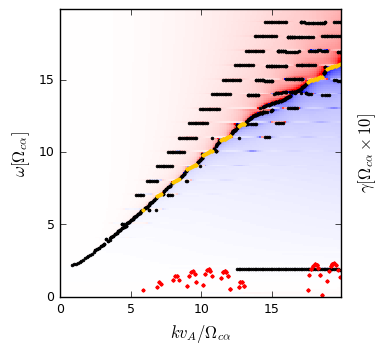

In [41]:

fig, ax, lbaxes = singleFigure()
im = ax.imshow((np.sign(insolution.real)/np.abs(insolution)**0.5).T, 
               aspect='auto', interpolation='nearest', extent=viewbounds, 
               vmin=-1E0, vmax=1E0, origin='lower', cmap='bwr')
ax.plot(root_k[stationarymask]/kunit, root_w[stationarymask].real/wunit, 
        ls='None', marker='.', color='black', markersize=4)
ax.plot(root_k[growthmask]/kunit, root_w[growthmask].real/wunit, 
        ls='None', marker='.', color='#FFC700', markersize=4)
ax.plot(root_k[growthmask]/kunit, root_w[growthmask].imag/wunit*10, 
        ls='None', marker='.', color='red', markersize=4)
ax.set_ylim(viewbounds[2], viewbounds[3])
ax.set_xlim(viewbounds[0], viewbounds[1])

ax.set_xlabel('$kv_{A}/\Omega_{c\\alpha}$', fontsize=fontsize)
ax.set_ylabel('$\omega[\Omega_{c\\alpha}]$', fontsize=fontsize)
lbaxes.set_ylabel('$\gamma[\Omega_{c\\alpha} \\times 10]$', 
                  fontsize=fontsize)

ax.tick_params('x', labelsize=labelsize)
ax.tick_params('y', labelsize=labelsize)